In [1]:
import math
import torch
import gpytorch
import numpy as np
import numpy.linalg as linalg

import spectralgp
from spectralgp.samplers import AlternatingSampler
from spectralgp.models import ExactGPModel, SpectralModel, ProductKernelSpectralModel
from spectralgp.sampling_factories import ss_factory, ess_factory

import data
import utils
import argparse

import sys
import matplotlib.pyplot as plt

import traceback

torch.set_default_dtype(torch.float64)

In [2]:
mlatent = 'shared'
model_avg = 'full'
nomg = 100
ess_iters = 10
optim_iters = 5 
iters = 20
torch.random.manual_seed(42)
shared = True if mlatent == 'shared' else False

In [3]:
data_x = torch.linspace(0, 5, 500)
# True function is sin(2*pi*x) with Gaussian noise
data_y = (0. + torch.sin(data_x * (2 * math.pi))) + torch.randn(data_x.size()) * 0.2
in_dims = 1

In [4]:
omega_0 = 1.e-10
omega_max = 8.
omega_data = torch.linspace(omega_0, omega_max, nomg)
omega_delta = omega_data[1] - omega_data[0]
phi_const = torch.sqrt(omega_delta/2.)

In [5]:
mapped_data_x = []
for obs_id in range(data_x.size(0)):
    mapped_data_x.append([])
    for omg_id in range(0, nomg):
        if omg_id == 0 or omg_id == nomg-1:
            mapped_data_x[obs_id].append(torch.cos(2.0*math.pi*omega_data[omg_id]*data_x[obs_id]))
            mapped_data_x[obs_id].append(torch.sin(2.0*math.pi*omega_data[omg_id]*data_x[obs_id]))
        else:
            mapped_data_x[obs_id].append(math.sqrt(2.0)*torch.cos(2.0*math.pi*omega_data[omg_id]*data_x[obs_id]))
            mapped_data_x[obs_id].append(math.sqrt(2.0)*torch.sin(2.0*math.pi*omega_data[omg_id]*data_x[obs_id]))

data_x = torch.DoubleTensor(mapped_data_x) * phi_const

In [6]:
train_x = data_x[0:250,:]
train_y = data_y[0:250]

test_x = data_x[250:,:]
test_y = data_y[250:]

print(train_x.size(), train_y.size())
print(test_x.size(), test_y.size())

torch.Size([250, 200]) torch.Size([250])
torch.Size([250, 200]) torch.Size([250])


In [7]:
data_mod = spectralgp.models.BayesianLinearRegressionModel(train_x, train_y, nomg, omega_0, omega_max)

################################
## set up alternating sampler ##
################################

alt_sampler = spectralgp.samplers.AlternatingSampler(
[data_mod],
spectralgp.sampling_factories.ss_factory, [spectralgp.sampling_factories.ess_factory],
totalSamples=iters, numInnerSamples=ess_iters, numOuterSamples=optim_iters, num_dims=in_dims
)
alt_sampler.run()

Loss is:  tensor(-5.4025, grad_fn=<AddBackward0>)
Loss is:  tensor(-5.3781, grad_fn=<AddBackward0>)
Loss is:  tensor(-5.3544, grad_fn=<AddBackward0>)
Loss is:  tensor(-5.3307, grad_fn=<AddBackward0>)
Loss is:  tensor(-5.3075, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 0
Seconds for Iteration 0 : 0.6471295356750488
Loss is:  tensor(-2.1012, grad_fn=<AddBackward0>)
Loss is:  tensor(-2.0993, grad_fn=<AddBackward0>)
Loss is:  tensor(-2.0987, grad_fn=<AddBackward0>)
Loss is:  tensor(-2.0983, grad_fn=<AddBackward0>)
Loss is:  tensor(-2.0975, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 1
Seconds for Iteration 1 : 0.5563626289367676
Loss is:  tensor(-1.8390, grad_fn=<AddBackward0>)
Loss is:  tensor(-1.8356, grad_fn=<AddBackward0>)
Loss is:  tensor(-1.8332, grad_fn=<AddBackward0>)
Loss is:  tensor(-1.8309, grad_fn=<AddBackward0>)
Loss is:  tensor(-1.8282, grad_fn=<AddBackward0>)
Task: 0 ; Iteration 2
Seconds for Iteration 2 : 0.5293064117431641
Loss is:  tensor(-1.8613, grad_fn=<AddBackward0>)

Test RMSE: 0.6500111476204421
torch.Size([500, 200]) torch.Size([500])
torch.Size([250, 200]) torch.Size([250, 200]) torch.Size([500, 200])


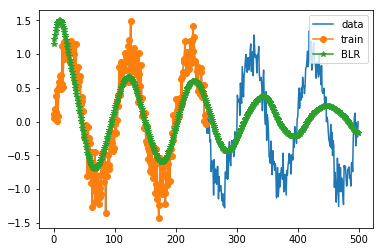

<Figure size 432x288 with 0 Axes>

In [8]:
data_mod.eval()

d = data_mod(test_x).mean - test_y

test_rmse = torch.sqrt(torch.mean(torch.pow(d, 2)))

print("Test RMSE: {}".format(test_rmse))

print(data_x.size(), data_y.size())
print(train_x.size(), test_x.size(), data_x.size())

plt.plot(data_y.numpy(), label='data')
plt.plot(train_y.numpy(), marker='o', label='train')
plt.plot(data_mod(data_x).mean.detach().numpy(), marker='*', label='BLR')
plt.legend()
plt.show()
plt.savefig("BLR_out.png")

#print(data_mod(data_x).mean.detach().numpy())